In [12]:
#모듈 임포트
import tensorf low as tf
import tensorflow_hub as tfhub

In [14]:
img_path = 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/c4/Gangnam_Seoul_January_2009.jpg/1280px-Gangnam_Seoul_January_2009.jpg'
img = tf.keras.utils.get_file(fname = 'Gangnam', origin = img_path)

#file 객체를 string으로 변환
img = tf.io.read_file(img)

#string을 숫자로 텐서 변환
img = tf.image.decode_jpeg(img, channels=3)

#정규화 0~1
img = tf.image.convert_image_dtype(img, tf.float32)

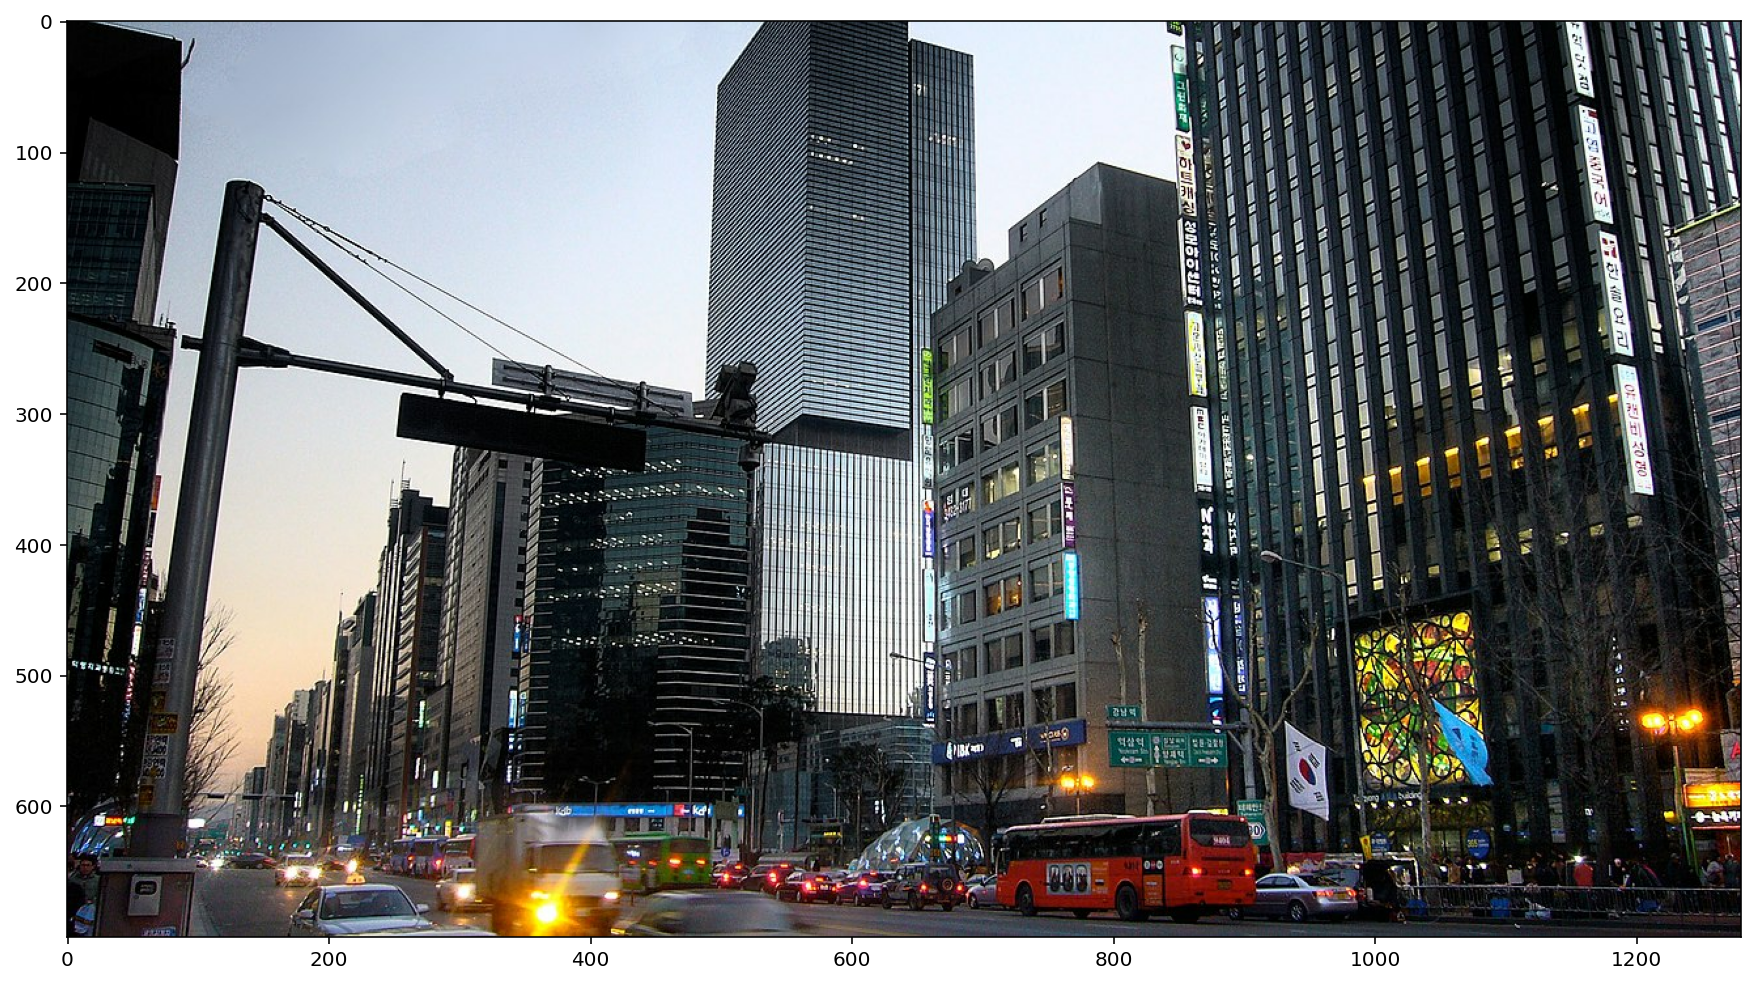

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 20))
plt.imshow(img)
plt.show()

### 이미지 4차원 변환

In [20]:
img_input = tf.expand_dims(img, 0)

print(img.shape)
print(img_input.shape)

(700, 1280, 3)
(1, 700, 1280, 3)


## Model 불러오기

In [21]:
model = tfhub.load('https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


#### Model signature 확인

In [25]:
model.signatures.keys()

KeysView(_SignatureMap({'default': <tensorflow.python.eager.wrap_function.WrappedFunction object at 0x000001AAA5C00D88>}))

#### 객체 탐지 모델 생성

In [24]:
obj_detector = model.signatures['default']
obj_detector

#### 모델을 이용하여 예측(predict)

In [28]:
result = obj_detector(img_input)
result.keys()

dict_keys(['detection_class_labels', 'detection_scores', 'detection_boxes', 'detection_class_entities', 'detection_class_names'])

#### 탐지한 객체의 수 - 100개

In [29]:
print(len(result['detection_scores']))

100


## Image Bounding Box 시각화
- `detection_boxes` : bounding box 좌표
    - `(ymax, xmin, ymin, xmax)`
        - `xmin, ymin (x1, y1)` : 왼쪽 위 모서리의 좌표.
        - `xmax, ymax (x2, y2)` : 오른쪽 밑 모서리의 좌표.
- `detection_class_entities` : 클래스 값 - 무엇으로 예측했는지
- `detection_scores` : 신뢰도. confidence

In [32]:
boxes = result['detection_boxes'] #bounding box 좌표 - 100개
labels = result['detection_class_entities'] #클래스 값 - 무엇으로 예측했는지
scores = result['detection_scores'] #신뢰도(confidence)

In [37]:
boxes[0]

<tf.Tensor: id=174301, shape=(4,), dtype=float32, numpy=array([0.8565289 , 0.553885  , 0.98553175, 0.71555555], dtype=float32)>

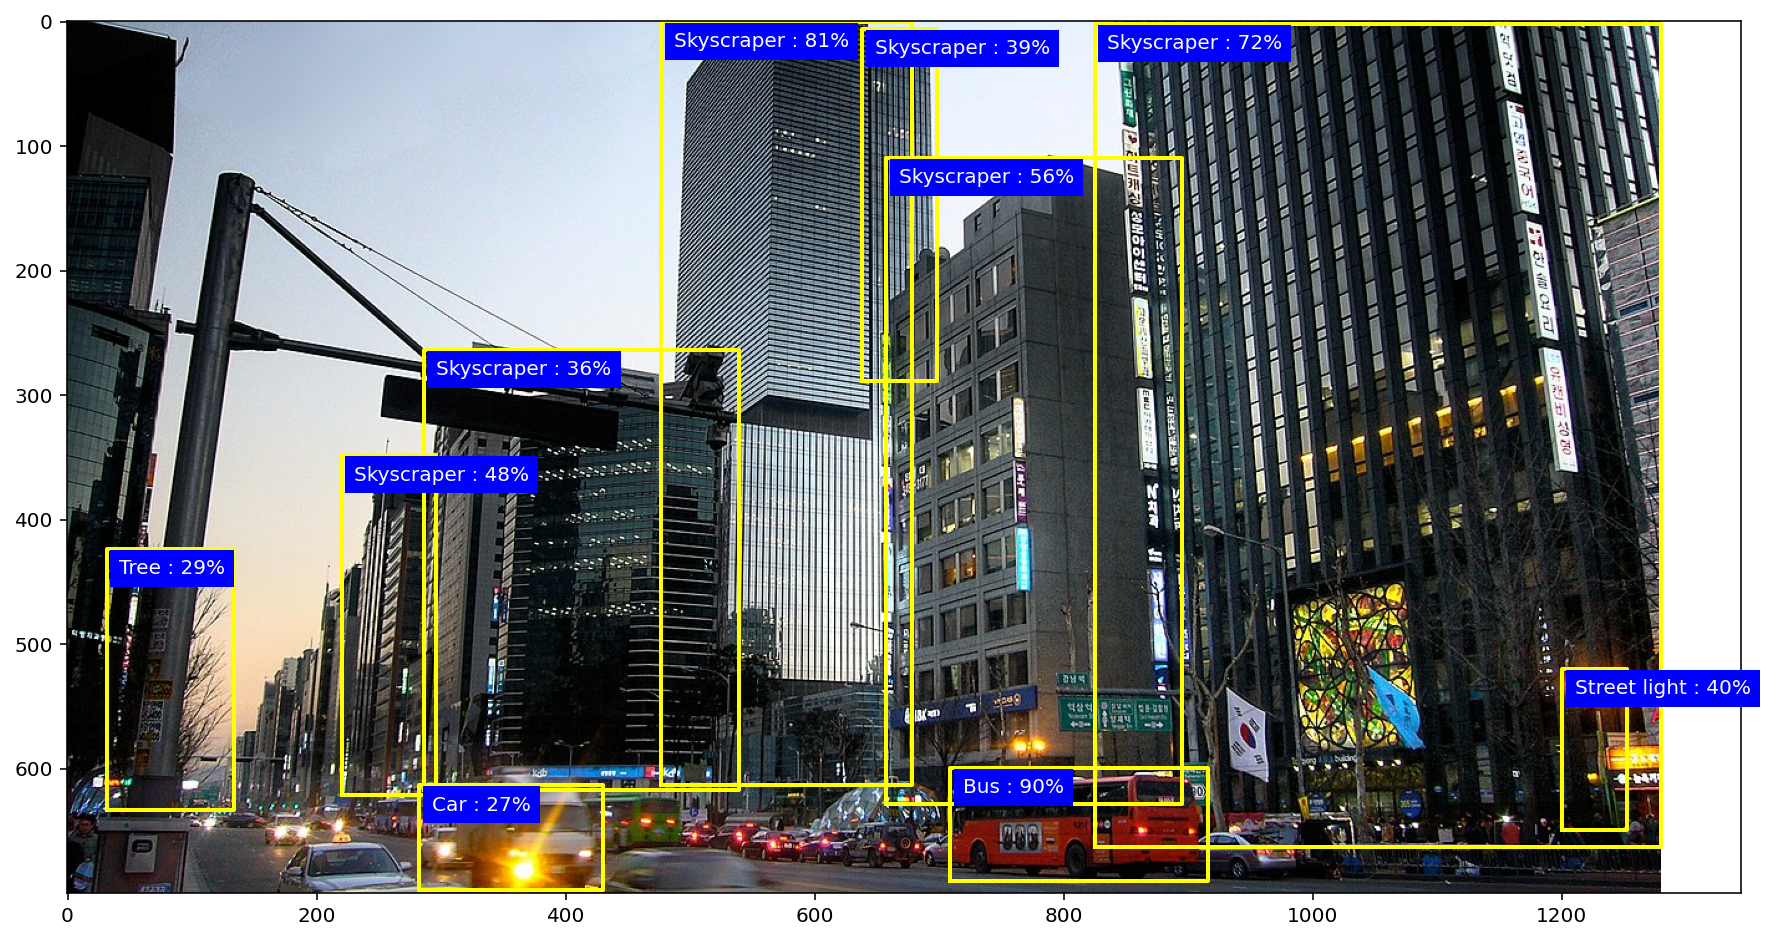

In [71]:
#Gangnam Image size (height, width)
img_height, img_width = img.shape[0], img.shape[1]

#obj_detection max number
obj_to_detect = 10
num_box = boxes.shape[0]

plt.figure(figsize=(15, 10))
plt.imshow(img)

for i in range(min(obj_to_detect, num_box)):
    #정확도 20% 이상
    if scores[i] > 0.2:
        (ymax, xmin, ymin, xmax) = (boxes[i][0] * img_height, boxes[i][1] * img_width, 
                                    boxes[i][2] * img_height, boxes[i][3] * img_width)
        
        #bounding box
        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], color='yellow', linewidth=2)
        
        #text
        class_name = labels[i].numpy().decode('utf-8') #label
        infer_score = int(scores[i].numpy()*100) #confidence
        annotation = '{} : {}%'.format(class_name, infer_score)
        
        plt.text(xmin.numpy()+10, ymax.numpy()+20, annotation, color='white', backgroundcolor='blue', fontsize=10)
#       plt.text(xmin+10, ymax+20, annotation, color='white', backgroundcolor='blue', fontsize=10)